# Deep Convolutional Generative Adversarial Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import imageio as imageio
from time import time
from pathlib import Path
from IPython.display import clear_output
plt.style.use('fivethirtyeight')
plt.rc('font', size=8)

In [2]:
NOISE_DIM = 128
EPOCHS = 1000
BATCH_SIZE = 128
IMAGES_PATH = Path('./images/gan_cifar/')
GIF_PATH = IMAGES_PATH / 'dcgan.gif'

## Загрузка данных (будем генерировать автомобили)

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

cifar = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

cifar = cifar[y[:, 0] == 1].astype('float32')
cifar = (cifar - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(cifar).batch(BATCH_SIZE)

(32, 32, 3)


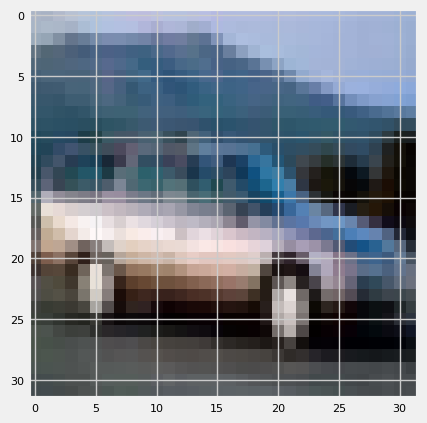

In [4]:
image = (cifar[0] + 1) / 2
print(image.shape)
plt.imshow(image)
plt.show()

## Разработка модели

### Генератор

In [5]:
def generator_model():
    generator_inputs = layers.Input(shape=(NOISE_DIM,))
    x = layers.Dense(4 * 4 * 128)(generator_inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((4, 4, 128))(x)

    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)

    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)

    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.Activation('tanh')(x)   

    return keras.Model(generator_inputs, x, name='generator')

In [6]:
generator = generator_model()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 2048)              264192    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        819456    
 nspose)                                                 

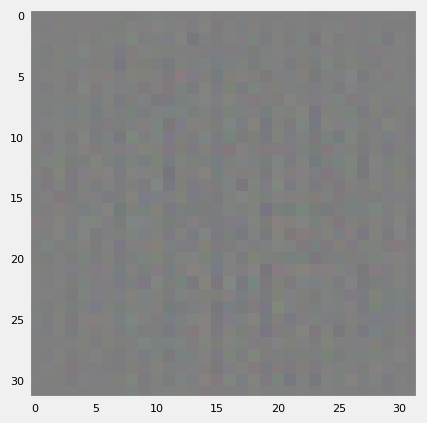

In [7]:
noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(noise, training=False)

image = (generated_image[0] + 1) / 2
plt.imshow(image)
plt.grid(False)
plt.show()

### Дискриминатор

In [8]:
def discriminator_model():
    discriminator_inputs = layers.Input(shape=(32, 32, 3))

    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(discriminator_inputs)
    x = layers.LeakyReLU()(x)

    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    
    return keras.Model(discriminator_inputs, x, name='discriminator')

In [9]:
discriminator = discriminator_model()
discriminator.summary()
print(discriminator(generated_image))

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                     

### Функции потерь и оптимизаторы

In [10]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = keras.optimizers.Adam(0.0003)
discriminator_optimizer = keras.optimizers.Adam(0.0003)

### Обучение модели

In [14]:
def generate_and_save_images(model, epoch, test_input):
    pred = model(test_input, training=False)

    plt.figure(figsize=(12, 6))
    for i in range(pred.shape[0]):
        plt.subplot(2, 4, i+1)
        image = (pred[i] + 1) / 2
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    
    img_path = IMAGES_PATH / f'image_at_epoch_{epoch:03}.png'
    plt.savefig(str(img_path))
    plt.show()

In [15]:
def plot_history(history):
    plt.figure(figsize=(10, 5))
    for key in ['generator_loss', 'discriminator_loss']:
        plt.plot(history[key], label=key)
        plt.grid(True)
        plt.legend()

    plt.show()

In [16]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [17]:
test_batch = tf.random.normal([8, NOISE_DIM])

def train(dataset, epochs):
    history = {'generator_loss': [],
               'discriminator_loss': []}

    generate_and_save_images(generator, 0, test_batch)
    for epoch in range(epochs):
        start = time()
        epoch_g_loss = 0
        epoch_d_loss = 0

        for batch in dataset:
            g_loss, d_loss = train_step(batch)
            epoch_g_loss += g_loss.numpy()
            epoch_d_loss += d_loss.numpy()

        history['generator_loss'].append(epoch_g_loss / len(dataset))
        history['discriminator_loss'].append(epoch_d_loss / len(dataset))

        clear_output(wait=True)
        print(f'Time for epoch {epoch+1} is {time()-start} sec')

        generate_and_save_images(generator, epoch+1, test_batch)
        plot_history(history)

    clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, test_batch)
    plot_history(history)
    return history

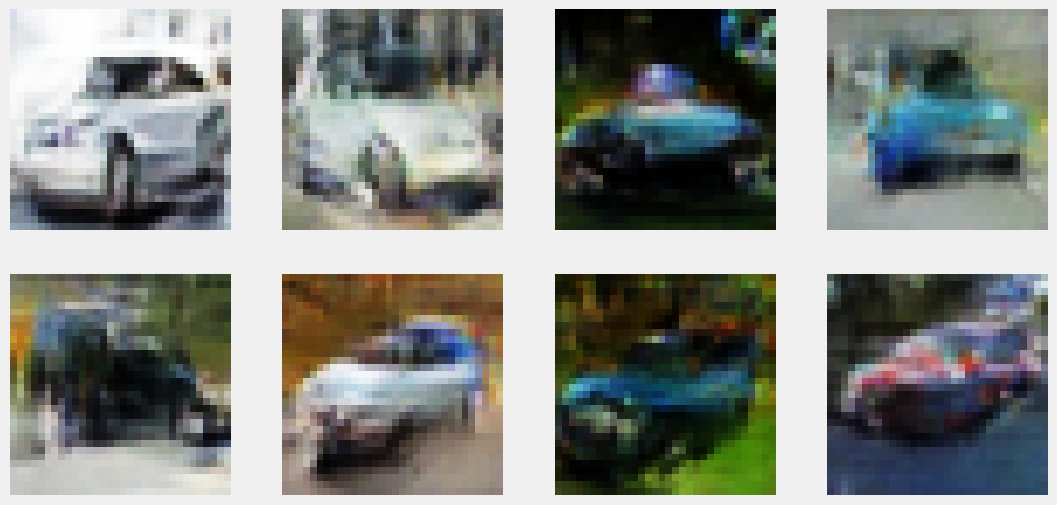

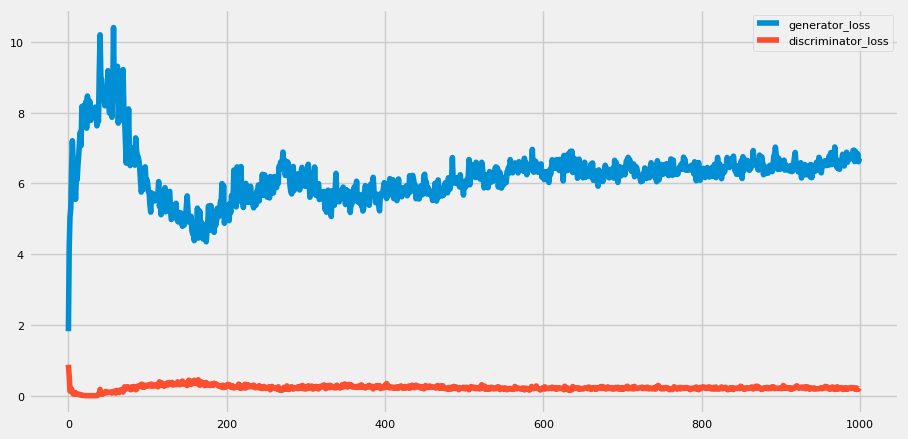

In [18]:
history = train(train_dataset, EPOCHS)

### Создадим гифку с процессом обучения

In [19]:
frames = []
files = IMAGES_PATH.glob('image_at_epoch_*.png')
files = sorted(files)
for file in files:
    frames.append(imageio.v3.imread(file))

imageio.mimsave(GIF_PATH, frames, loop=0)

<img src="images\gan_cifar\dcgan.gif" width="750" align="center">